Final Proyek Sains Data
-  Joseph Honesty Ambanaga (IF22G) 22416255201043
- Cliff Jordan Jonah Amabanaga (IF22G) 22416255201123

In [104]:
# BAGIAN 1: SETUP, PRA-PEMROSESAN, DAN VISUALISASI
# --- 1.1 Import Library yang Dibutuhkan ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [105]:
# Ini adalah data mentah yang kami gunakan, DataFrame yang pertama kali dimuat dari file CSV. Isinya masih belum diproses—memiliki banyak kolom yang tidak relevan, nilai yang hilang (NaN), tipe data yang salah (misalnya, harga sebagai teks), dan outlier.
df = pd.read_csv('listings.csv')

# 1. Tampilkan 5 baris pertama data
print("Lima baris pertama (df.head()):")
print(df.head())

# 2. Tampilkan daftar semua kolom
print("\nDaftar Kolom (df.columns):")
print(df.columns)

# 3. Tampilkan informasi tipe data dan nilai yang hilang (missing values)
print("\nInformasi Data (df.info()):")
df.info()

Lima baris pertama (df.head()):
     id                        listing_url       scrape_id last_scraped  \
0  2539  https://www.airbnb.com/rooms/2539  20250617032754   2025-06-17   
1  2595  https://www.airbnb.com/rooms/2595  20250617032754   2025-06-17   
2  5136  https://www.airbnb.com/rooms/5136  20250617032754   2025-06-17   
3  6848  https://www.airbnb.com/rooms/6848  20250617032754   2025-06-17   
4  6872  https://www.airbnb.com/rooms/6872  20250617032754   2025-06-17   

            source                                               name  \
0      city scrape   Superfast Wi-Fi.  Clean & quiet home by the park   
1      city scrape           Skylit Midtown Manhattan Spacious Studio   
2      city scrape    Spacious Family Friendly Duplex w/ Patio + Yard   
3      city scrape                   Only 2 stops to Manhattan studio   
4  previous scrape  Uptown Sanctuary w/ Private Bath (Month to Month)   

                                         description  \
0  Bright, serene room

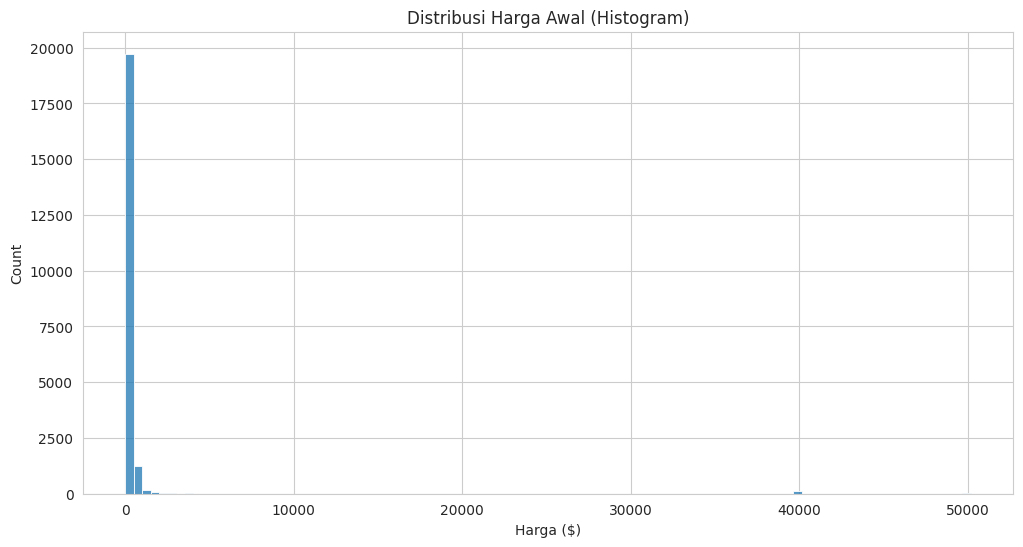

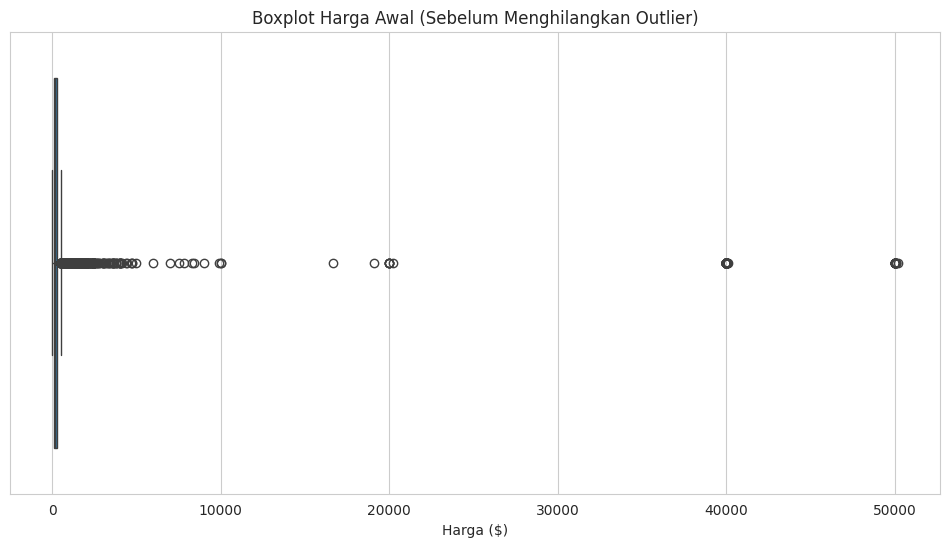

In [106]:
# --- 1.2 Konfigurasi Awal & Pra-pemrosesan ---
# Atur gaya plot
sns.set_style('whitegrid')

#'df' adalah DataFrame awal Anda yang sudah dimuat
df_processed = df.copy()

# --- Visualisasi Harga Awal ---
price_temp = pd.to_numeric(df_processed['price'].str.replace('[\$,]', '', regex=True), errors='coerce')

#memunculkan tabel histogram 'price' data asli
plt.figure(figsize=(12, 6))
sns.histplot(price_temp.dropna(), bins=100, kde=False)
plt.title('Distribusi Harga Awal (Histogram)')
plt.xlabel('Harga ($)')
plt.show()

print("")

plt.figure(figsize=(12, 6))
sns.boxplot(x=price_temp.dropna())
plt.title('Boxplot Harga Awal (Sebelum Menghilangkan Outlier)')
plt.xlabel('Harga ($)')
plt.show()

In [107]:
# --- Daftar kolom untuk diproses ---

# COLS_TO_DROP adalah kolom yang kami drop manual karena kami anggap tidak penting/tidak berpengaruh terhadap harga
COLS_TO_DROP = [
    'listing_url', 'scrape_id', 'picture_url', 'host_url', 'host_id', 'host_thumbnail_url',
    'host_picture_url', 'name', 'description', 'neighborhood_overview', 'host_about',
    'host_name', 'source', 'license', 'calendar_updated', 'neighbourhood', 'bathrooms',
    'host_location', 'host_listings_count', 'bathrooms_text', 'last_scraped',
    'host_since', 'first_review', 'last_review', 'calendar_last_scraped',
    'amenities', 'host_verifications'
]

# PERCENT_COLS adalah kolom yang memiliki data dengan nilai persentase
PERCENT_COLS = ['host_response_rate', 'host_acceptance_rate']

# BOOL_COLS adalah kolom yang berisi data dengan nilai boolena (yes/no)
BOOL_COLS = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
    'has_availability', 'instant_bookable'
]

In [108]:
# --- Menjalankan Pra-pemrosesan ---
# membuang kolom tidak relevan
cols_exist_in_df = [col for col in COLS_TO_DROP if col in df_processed.columns]
df_processed = df_processed.drop(columns=cols_exist_in_df)

# disini kami membersihkan dan mentransformasi Harga (Termasuk Menghilangkan Outlier)
df_processed.dropna(subset=['price'], inplace=True)
df_processed['price'] = df_processed['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float) #menghilangkan tanda '$' dan ',' agar data price menjadi numerik
price_percentile = df_processed['price'].quantile(0.99) #membuang 1% data harga teratas (outlier) karena dapat mengganggu pemodelan
df_processed = df_processed[(df_processed['price'] > 0) & (df_processed['price'] <= price_percentile)]

# berikut hasil pengecekan data
print("\nInformasi Data (df.info()):")
df_processed.info()


Informasi Data (df.info()):
<class 'pandas.core.frame.DataFrame'>
Index: 21244 entries, 0 to 36321
Data columns (total 52 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            21244 non-null  int64  
 1   host_response_time                            18037 non-null  object 
 2   host_response_rate                            18037 non-null  object 
 3   host_acceptance_rate                          17875 non-null  object 
 4   host_is_superhost                             20850 non-null  object 
 5   host_neighbourhood                            17005 non-null  object 
 6   host_total_listings_count                     21239 non-null  float64
 7   host_has_profile_pic                          21239 non-null  object 
 8   host_identity_verified                        21239 non-null  object 
 9   neighbourhood_cleansed               


Membuat visualisasi setelah menghilangkan harga ekstrem...


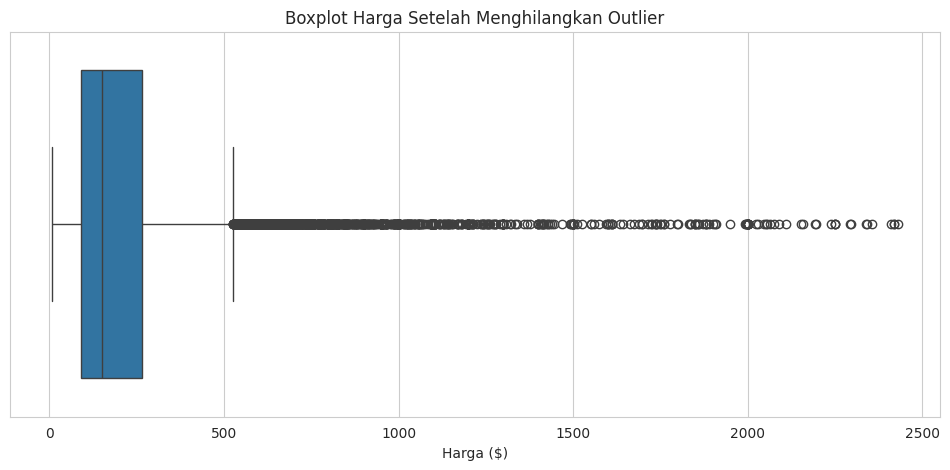

In [109]:
# --- Visualisasi Harga Setelah Dibersihkan ---
print("\nMembuat visualisasi setelah menghilangkan harga ekstrem...")
plt.figure(figsize=(12, 5))
sns.boxplot(x=df_processed['price'])
plt.title('Boxplot Harga Setelah Menghilangkan Harga Ekstrem')
plt.xlabel('Harga ($)')
plt.show()

In [110]:
# Konversi tipe data lainnya

# Menggunakan metode re-assignment untuk menghindari FutureWarning dari collab
df_processed['reviews_per_month'] = df_processed['reviews_per_month'].fillna(0)
numeric_cols = df_processed.select_dtypes(include=np.number).columns.tolist()

# Loop untuk mengisi kolom numerik yang barisnya kosong
for col in numeric_cols:
    if df_processed[col].isnull().any():
        median_val = df_processed[col].median()
        df_processed.loc[:, col] = df_processed[col].fillna(median_val)

# Loop untuk mengisi kolom kategorikal yang barisnya kosong
categorical_cols = df_processed.select_dtypes(include='object').columns
for col in categorical_cols:
    if df_processed[col].isnull().any():
        mode_val = df_processed[col].mode()[0]
        df_processed.loc[:, col] = df_processed[col].fillna(mode_val)

# kami menggunakan One-Hot Encoding untuk semua fitur/kolom kategorikal agar mengubah data kategorikal (yang berbentuk teks atau label) menjadi format numerik (angka 0 dan 1) agar bisa dipahami oleh model machine learning.
categorical_cols_to_encode = df_processed.select_dtypes(include=['object']).columns

# df_final adalah data bersih kami. Variabel ini adalah hasil setelah kami melakukan semua langkah pembersihan pada df: membuang kolom tidak perlu, membersihkan outlier harga, mengubah tipe data, dan menangani semua nilai yang hilang (imputasi).
df_final = pd.get_dummies(df_processed, columns=categorical_cols_to_encode, drop_first=True)

print(f"\nPra-pemrosesan selesai. Bentuk data final: {df_final.shape}")

#berikut informasi data yang sudah selesai
df_final.info()


Pra-pemrosesan selesai. Bentuk data final: (21244, 968)
<class 'pandas.core.frame.DataFrame'>
Index: 21244 entries, 0 to 36321
Columns: 968 entries, id to instant_bookable_t
dtypes: bool(929), float64(17), int64(22)
memory usage: 25.3 MB


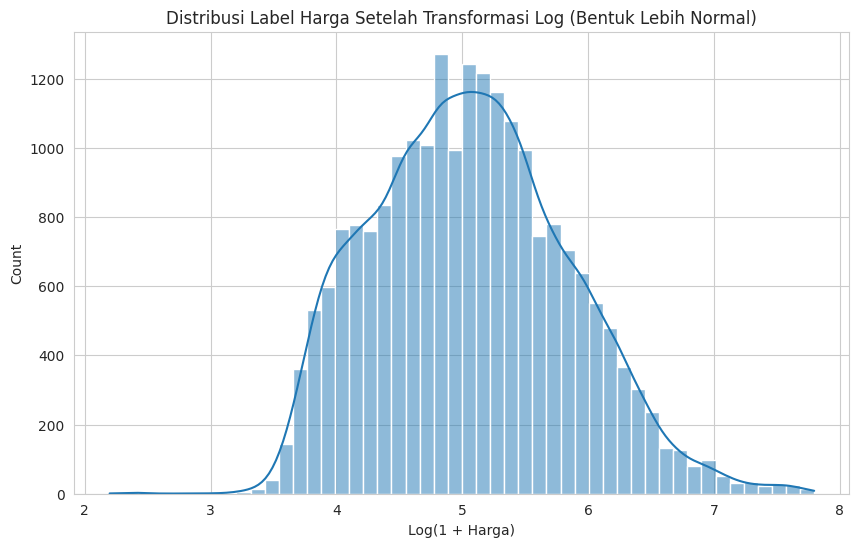

In [111]:
# BAGIAN 2: PERSIAPAN AKHIR DATA UNTUK MODELING
# --- 2.1 Pisahkan Fitur (X) dan Label (y) & Transformasi Log ---

# X berisi semua kolom dari df_final kecuali kolom harga (price). X berisi semua informasi yang akan digunakan untuk membuat prediksi.
X = df_final.drop('price', axis=1)

# y berisi harga yang telah ditransformasi secara logaritmik (np.log1p(price)). Transformasi ini dilakukan agar distribusi harga menjadi lebih normal, yang membantu model belajar lebih baik.
y = np.log1p(df_final['price'])

# --- Visualisasi Label Setelah Transformasi Log ---
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=50, kde=True)
plt.title('Distribusi Label Harga Setelah Transformasi Log (Bentuk Lebih Normal)')
plt.xlabel('Log(1 + Harga)')
plt.show()

In [112]:
# --- 2.2 Bagi Data & Lakukan Penskalaan (Normalisasi) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [113]:
# BAGIAN 3: ANALISIS SELEKSI FITUR (MENCARI METODE SELEKSI TERBAIK)
# List untuk menyimpan hasil perbandingan
comparison_results = []


# 1. Baseline - Menggunakan Semua Fitur. kami menggunakan model linear regression yang berfungsi sebagai tolak ukur metode seleksi yang lain
print("--- 1. Menghitung Baseline (Semua Fitur) ---")
lr_baseline = LinearRegression()
lr_baseline.fit(X_train, y_train)
y_pred_baseline = lr_baseline.predict(X_test)
r2_baseline = r2_score(y_test, y_pred_baseline)
comparison_results.append({
    'Metode Seleksi': 'Baseline (Semua Fitur)',
    'Jumlah Fitur': X_train.shape[1],
    'R-squared Score': r2_baseline
})
print(f"R-squared Baseline: {r2_baseline:.4f}\n")


# 2. Analisis dengan Lasso. Semakin tinggi nilai alpha, semakin sedikit fitur yang terpilih
print("--- 2. Menganalisis untuk Lasso ---")
alphas_to_test = [0.001, 0.005, 0.01, 0.015, 0.02, 0.03]

for alpha_val in alphas_to_test:
    # Latih model Lasso untuk mendapatkan jumlah fitur
    lasso_model = Lasso(alpha=alpha_val, random_state=42)
    lasso_model.fit(X_train, y_train)
    num_features = np.sum(lasso_model.coef_ != 0)

    # Latih Linear Regression pada fitur yang dipilih Lasso
    selected_cols = X_train.columns[lasso_model.coef_ != 0]
    lr_on_lasso = LinearRegression()
    lr_on_lasso.fit(X_train[selected_cols], y_train)
    y_pred = lr_on_lasso.predict(X_test[selected_cols])
    r2 = r2_score(y_test, y_pred)

    comparison_results.append({
        'Metode Seleksi': f"Lasso (alpha={alpha_val})",
        'Jumlah Fitur': num_features,
        'R-squared Score': r2
    })
    print(f"Alpha: {alpha_val:<7} | Fitur Terpilih: {num_features:<4} | R-squared: {r2:.4f}")
print("")

--- 1. Menghitung Baseline (Semua Fitur) ---
R-squared Baseline: 0.7794

--- 2. Menganalisis untuk Lasso ---
Alpha: 0.001   | Fitur Terpilih: 706  | R-squared: 0.7801
Alpha: 0.005   | Fitur Terpilih: 284  | R-squared: 0.7764
Alpha: 0.01    | Fitur Terpilih: 136  | R-squared: 0.7714
Alpha: 0.015   | Fitur Terpilih: 74   | R-squared: 0.7636
Alpha: 0.02    | Fitur Terpilih: 54   | R-squared: 0.7551
Alpha: 0.03    | Fitur Terpilih: 40   | R-squared: 0.7465



In [114]:
# ==============================================================================
# 3. Langkah Tambahan: Seleksi Fitur dengan Random Forest Importance
# ==============================================================================
print("--- 3. Seleksi Fitur dengan Random Forest Importance ---")

# Latih model Random Forest pada semua fitur
rf_for_importance = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_for_importance.fit(X_train, y_train)

# Buat Series untuk melihat fitur mana yang paling penting
feature_importances = pd.Series(rf_for_importance.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Pilih N fitur teratas (misalnya, kita ambil 100 fitur teratas)
N_TOP_FEATURES = 40
selected_cols_rf = feature_importances.head(N_TOP_FEATURES).index.tolist()

# Latih Linear Regression pada fitur yang dipilih Random Forest
X_train_rf = X_train[selected_cols_rf]
X_test_rf = X_test[selected_cols_rf]
lr_on_rf = LinearRegression()
lr_on_rf.fit(X_train_rf, y_train)
y_pred_rf = lr_on_rf.predict(X_test_rf)
r2_rf = r2_score(y_test, y_pred_rf)

comparison_results.append({
    'Metode Seleksi': f"Random Forest (Top {N_TOP_FEATURES})",
    'Jumlah Fitur': N_TOP_FEATURES,
    'R-squared Score': r2_rf
})
print(f"Fitur Terpilih: {N_TOP_FEATURES} | R-squared: {r2_rf:.4f}\n")

--- 3. Seleksi Fitur dengan Random Forest Importance ---
Fitur Terpilih: 40 | R-squared: 0.6881



In [115]:
# ==============================================================================
# Rangkuman Hasil Akhir
# ==============================================================================
summary_df = pd.DataFrame(comparison_results)
summary_df = summary_df.sort_values(by='R-squared Score', ascending=False)

print("--- Rangkuman Perbandingan Hasil Seleksi Fitur ---")
print(summary_df.to_string(index=False))

--- Rangkuman Perbandingan Hasil Seleksi Fitur ---
        Metode Seleksi  Jumlah Fitur  R-squared Score
   Lasso (alpha=0.001)           706         0.780090
Baseline (Semua Fitur)           967         0.779442
   Lasso (alpha=0.005)           284         0.776419
    Lasso (alpha=0.01)           136         0.771415
   Lasso (alpha=0.015)            74         0.763587
    Lasso (alpha=0.02)            54         0.755075
    Lasso (alpha=0.03)            40         0.746492
Random Forest (Top 40)            40         0.688100


In [116]:
# --- 3.1 Buat Keputusan Metode Seleksi Terbaik ---
# Berdasarkan tabel di atas, kami memilih Lasso dengan alpha 0.01
# karena jumlah fitur yang lebih sedikit dengan nilai R-squared yang tidak begitu jauh dari metode dengan score tertinggi
best_alpha = 0.01
print(f"\nAlpha yang dipilih untuk seleksi fitur final: {best_alpha}")



Alpha yang dipilih untuk seleksi fitur final: 0.01


In [117]:
# ==============================================================================
# BAGIAN 4: SELEKSI FITUR FINAL & EVALUASI MODEL UNGGULAN
# ==============================================================================
final_lasso_selector = SelectFromModel(Lasso(alpha=best_alpha, random_state=42))
final_lasso_selector.fit(X_train, y_train)

# 'selected_cols_final' adalah list yang berisi nama-nama kolom (fitur) yang berhasil lolos dari seleksi Lasso.
selected_cols_final = X_train.columns[(final_lasso_selector.get_support())]

# Buat dataset final
X_train_final = X_train[selected_cols_final]
X_test_final = X_test[selected_cols_final]

print(f"Jumlah fitur final yang akan digunakan: {len(selected_cols_final)}")

# --- Menampilkan Daftar Fitur ---
print("\n=== Daftar Fitur Pilihan Final ===")
print(selected_cols_final.tolist())

Jumlah fitur final yang akan digunakan: 136

=== Daftar Fitur Pilihan Final ===
['host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'minimum_minimum_nights', 'availability_30', 'availability_60', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'host_response_time_within an hour', 'host_response_rate_100%', 'host_response_rate_35%', 'host_response_rate_43%', 'host_response_rate_47%', 'host_response_rate_79%', 'host_response_rate_80%', 'host_response_rate_86%', 'host_response_rate_92%', 'host_response_rate_95%', 'host_acceptance_rate_100%', 'host_acceptance_rate_33%', 'host_acceptance_rate_47%', 'host_acceptance_rate_52%', 'host_acceptance_rate_55%', 'host_acceptance_rate_61%', 'host_acceptance_rate_62%', 'host_acceptance_ra

In [123]:
# --- 4.1 Melatih dan Mengevaluasi Model-model Unggulan ---
print("\n--- Melatih Semua Model Unggulan pada Fitur Pilihan Final ---")
models_to_evaluate = {
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(random_state=42, n_jobs=-1)
}
final_results = []
for name, model in models_to_evaluate.items():
    print(f"Melatih {name}...")
    model.fit(X_train_final, y_train)

    # Prediksi mentah dari model, masih dalam skala logaritmik.
    y_pred_log = model.predict(X_test_final)

    # 1. Hitung error dalam skala logaritmik
    mae_log = mean_absolute_error(y_test, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))

    # 2. Kembalikan ke skala Dolar dan hitung errornya
    y_pred_dollar = np.expm1(y_pred_log)
    y_test_dollar = np.expm1(y_test)
    mae_dollar = mean_absolute_error(y_test_dollar, y_pred_dollar)
    rmse_dollar = np.sqrt(mean_squared_error(y_test_dollar, y_pred_dollar))

    # 3. Simpan semua hasil metrik
    final_results.append([name, mae_dollar, rmse_dollar, mae_log, rmse_log])

# Buat DataFrame dengan kolom-kolom baru
final_results_df = pd.DataFrame(
    final_results,
    columns=['Model', 'MAE ($)', 'RMSE ($)', 'MAE (log)', 'RMSE (log)']
).sort_values(by='MAE ($)')

# --- PERUBAHAN SELESAI DI SINI ---

print("\n--- Peringkat Model Final (dengan Perbandingan Skala) ---")
print(final_results_df.to_string(index=False))


--- Melatih Semua Model Unggulan pada Fitur Pilihan Final ---
Melatih Ridge Regression...
Melatih Random Forest...
Melatih XGBoost...
Melatih LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1749
[LightGBM] [Info] Number of data points in the train set: 16995, number of used features: 118
[LightGBM] [Info] Start training from score 5.066710

--- Peringkat Model Final (dengan Perbandingan Skala) ---
           Model   MAE ($)   RMSE ($)  MAE (log)  RMSE (log)
         XGBoost 45.145706 117.419582   0.183070    0.281871
   Random Forest 45.813780 121.297857   0.187834    0.295104
        LightGBM 46.432842 119.650878   0.188259    0.285244
Ridge Regression 68.093411 281.246481   0.275598    0.3

In [119]:
# ==============================================================================
# BAGIAN 5: MENENTUKAN & MENYIMPAN MODEL JUARA UNTUK DEPLOYMENT
# ==============================================================================
# --- 5.1 Pilih Model Juara Anda ---
# Berdasarkan tabel di atas, model dengan MAE terendah adalah juaranya.

champion_model_name = final_results_df.iloc[0]['Model']
print(f"\nModel juara yang dipilih adalah: {champion_model_name}")


Model juara yang dipilih adalah: XGBoost


Model XGBoost secara konsisten menunjukkan performa terbaik di antara semua model yang diuji. Dengan Mean Absolute Error (MAE) sebesar $45.14, model ini memiliki tingkat kesalahan rata-rata terendah dalam memprediksi harga sewa properti. Ini menjadikannya model pilihan utama kami untuk tahap penerapan.

In [120]:
# --- 5.2 Latih Kembali Model Juara pada Seluruh Data Training & Simpan ---
print("Melatih kembali model juara pada seluruh data training...")
# Inisialisasi model juara sesuai namanya
if champion_model_name == 'XGBoost':
    champion_model = XGBRegressor(random_state=42, n_jobs=-1)
elif champion_model_name == 'LightGBM':
    champion_model = LGBMRegressor(random_state=42, n_jobs=-1)
elif champion_model_name == 'Random Forest':
    champion_model = RandomForestRegressor(random_state=42, n_jobs=-1)
else: # Ridge
    champion_model = Ridge()

# Latih pada data dengan fitur yang sudah diseleksi
champion_model.fit(X_train_final, y_train)
print("Model juara selesai dilatih.")

Melatih kembali model juara pada seluruh data training...
Model juara selesai dilatih.


In [121]:
# --- Simpan model dan scaler untuk aplikasi Streamlit ---
joblib.dump(champion_model, 'final_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(selected_cols_final.to_list(), 'final_model_features.joblib')
joblib.dump(X_train.columns.to_list(), 'all_scaler_features.joblib')
print("\nModel juara, scaler, dan daftar fitur telah disimpan. Siap untuk deployment!")


Model juara, scaler, dan daftar fitur telah disimpan. Siap untuk deployment!


In [122]:
# TAMBAHAN
# Membuat pemetaan wilayah pada kota New York dengan 4 fitur/kolom ini: 'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'latitude', 'longitude'
required_cols = ['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'latitude', 'longitude']
if not all(col in df.columns for col in required_cols):
    print("Error: Kolom yang dibutuhkan tidak ditemukan di DataFrame asli.")
else:
    # Kelompokkan data untuk mendapatkan batas min/max untuk setiap lingkungan
    geo_bounds = df.groupby(['neighbourhood_group_cleansed', 'neighbourhood_cleansed']).agg(
        lat_min=('latitude', 'min'),
        lat_max=('latitude', 'max'),
        lon_min=('longitude', 'min'),
        lon_max=('longitude', 'max')
    ).reset_index()

    # Buat struktur dictionary bersarang (nested dictionary)
    geo_data = {}
    for _, row in geo_bounds.iterrows():
        borough = row['neighbourhood_group_cleansed']
        neighbourhood = row['neighbourhood_cleansed']

        if borough not in geo_data:
            geo_data[borough] = {}

        geo_data[borough][neighbourhood] = {
            'lat_min': row['lat_min'],
            'lat_max': row['lat_max'],
            'lon_min': row['lon_min'],
            'lon_max': row['lon_max']
        }

    # Simpan dictionary sebagai file JSON
    with open('geo_data.json', 'w') as f:
        json.dump(geo_data, f, indent=4)

    print("File 'geo_data.json' berhasil dibuat!")

File 'geo_data.json' berhasil dibuat!
